In [309]:
pip install pyarrow pandas_ta seaborn matplotlib scikit-learn==1.3.1 yfinance tensorflow.keras



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [310]:
import pandas as pd
import pandas_ta as ta
from numpy import NaN
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score , mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.linear_model import LogisticRegression
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

import os
import yfinance as yf
warnings.filterwarnings("ignore")


In [311]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
import yfinance as yf
warnings.filterwarnings("ignore")

# df must have index as datetime64[ns], and 'signal' column
# freq can be 'daily', 'hourly', or 'minute'
def run_backtest(df, freq='h',name=""):

  # check if df.index is datetime64[ns]
  if df.index.dtype != 'datetime64[ns]':
    raise ValueError("df.index must be in datetime64[ns]")

  # ------------------ Return Data Preparation ------------------
  if 'return_forward' in df.columns:
    df = df.drop(columns=['return_forward'])

  if freq == 'd':
    df = concat_return(df, freq)
    period_in_a_year = 365
  elif freq == 'h':
    df = concat_return(df, freq)
    period_in_a_year = 365 * 24
  elif freq == '5min':
    df = concat_return(df, freq)
    period_in_a_year = 365 * 24 * 12
  elif freq == '15min':
    df = concat_return(df, freq)
    period_in_a_year = 365 * 24 * 4
  else:
    raise ValueError("Invalid freq argument. Must be 'd', 'h', '5min', or '15min'")

  # ------------------ Data check ------------------
  if df['signal'].isnull().values.any():
    raise ValueError("DataFrame contains NA values")
  if 'signal' not in df.columns:
    raise ValueError("DataFrame is missing required column: 'signal'")

  # ------------------ Return & Sharpe ------------------
  # Daily returns
  df['strategy_return'] = df['signal'] * df['return_forward']

  # Geometric Annual Return
  num_periods = len(df)
  annual_return_geometric = (1 + df['strategy_return']).prod()**(period_in_a_year/num_periods) - 1
  
  # Arithmetic Annual Return for sharpe ratio calculation
  annual_return_arithmetic = df['strategy_return'].mean() * period_in_a_year

  # Sharpe Ratio
  daily_std = df['strategy_return'].std()
  annual_std = daily_std * np.sqrt(period_in_a_year)
  overall_sharpe = annual_return_arithmetic / annual_std

  print(f"Overall Annual Return: {round(annual_return_geometric*100, 2)}%")
  print("Overall Annual Sharpe Ratio:", round(overall_sharpe, 4))

  # ------------------ Maximum Drawdown ------------------
  df['cum_return'] = (1 + df['strategy_return']).cumprod()
  rolling_max = df['cum_return'].cummax()
  df['drawdown'] = (df['cum_return'] - rolling_max) / rolling_max
  max_drawdown = df['drawdown'].min()
  print("Maximum Drawdown:", round(max_drawdown * 100, 2), "%")

  # ------------------ Win/Loss Ratio ------------------
  # winning_trades = (df['strategy_return'] > 0).sum()
  # losing_trades = (df['strategy_return'] < 0).sum()
  # if losing_trades > 0:
  #   win_loss_ratio = winning_trades / losing_trades
  # else:
  #   win_loss_ratio = np.nan # no losing trades (advoid division by zero)
  # print("Win/Loss Ratio:", round(win_loss_ratio, 4))

  # ------------------ Alpha and Beta ------------------
  # Beta = Cov(strategy_return, acutal_return) / Var(actual_return)
  cov_matrix = np.cov(df['strategy_return'], df['return_forward'])
  beta = cov_matrix[0, 1] / cov_matrix[1, 1]

  # Alpha = mean(strategy_return) - Beta * mean(actual_return)
  alpha_daily = df['strategy_return'].mean() - beta * df['return_forward'].mean()

  # Annualize alpha
  alpha_annualized = (1 + alpha_daily) ** period_in_a_year - 1

  print("Alpha:", round(alpha_annualized, 4))
  print("Beta:", round(beta, 4))

  # ------------------- Yearly Metrics -------------------
  df['year'] = df.index.year

  yearly_data = df.groupby('year').apply(lambda subdf: pd.Series({
    'yearly_return': (1 + subdf['strategy_return']).prod()**(period_in_a_year/len(subdf)) - 1,
    'yearly_return_arithmetic': subdf['strategy_return'].mean() * period_in_a_year,
    'yearly_std': subdf['strategy_return'].std() * np.sqrt(period_in_a_year),
    'yearly_beta': np.cov(subdf['strategy_return'], subdf['return_forward'])[0,1] /
                    np.cov(subdf['strategy_return'], subdf['return_forward'])[1,1],
    'yearly_alpha': (
      subdf['strategy_return'].mean()
      - (
        np.cov(subdf['strategy_return'], subdf['return_forward'])[0,1]
        / np.cov(subdf['strategy_return'], subdf['return_forward'])[1,1]
      )
      * subdf['return_forward'].mean()
    ) * period_in_a_year
  })).reset_index()

  yearly_data['yearly_sharpe'] = yearly_data['yearly_return_arithmetic'] / yearly_data['yearly_std']
  yearly_data.drop(columns=['yearly_return_arithmetic'], inplace=True)
  print("\nYearly Metrics:")
  print(yearly_data)

  # ------------------------- Plots ----------------------
  df['cum_return_plot'] = (1 + df['strategy_return']).cumprod() - 1
  df['bh_cum_return_plot'] = (1 + df['return_forward']).cumprod() - 1

  # cumulative return plot
  plt.figure(figsize=(8,4))
  plt.plot(df.index, df['cum_return_plot'], label='Strategy Return')
  plt.plot(df.index, df['bh_cum_return_plot'], label='Buy and Hold')
  plt.title('Strategy Cumulative Return')
  plt.xlabel('Date')
  plt.ylabel('Cumulative Return')
  plt.legend()
  plt.savefig(f'{name}_cumulative_return.png')
  plt.show()

  # Signal weight plot
  plt.figure(figsize=(8,4))
  plt.plot(df.index, df['signal'], label='Signal')
  plt.title('Signal Weight Over Time')
  plt.xlabel('Date')
  plt.ylabel('Weight')
  plt.legend()
  plt.savefig(f'{name}_signal_weight.png')
  plt.show()


def concat_return(df, freq='h'):
  if freq == 'd':
    file_path = "../../bitcoin_historical_price/btcusd_daily_price.parquet"
  elif freq == 'h':
    file_path = "../../bitcoin_historical_price/btcusd_hourly_price.parquet"
  elif freq == '5min':
    file_path = "../../bitcoin_historical_price/btcusd_5min_price.parquet"
  elif freq == '15min':
    file_path = "../../bitcoin_historical_price/btcusd_15min_price.parquet"
  else:
    raise ValueError("Invalid freq argument. Must be 'd', 'h', '5min', or '15min'")

  if os.path.exists(file_path):
    df_btc_return = pd.read_parquet(file_path)
  else:
    raise FileNotFoundError("Check file path: return data not found.")

  # merge return_forward to df
  merged_df = pd.merge(df, df_btc_return[['return_forward']], left_index=True, right_index=True, how='inner')

  # turn return_forward from decimal to float
  merged_df['return_forward'] = merged_df['return_forward'].apply(lambda x: float(x))
  return merged_df

In [312]:
price_indicator = pd.read_parquet("/workspaces/fyp/bitcoin_historical_price/btcusd_hourly_price_indicators.parquet")
df = pd.read_parquet("../data/full_dataset_feature_engineering_v2.parquet")

In [313]:
df.drop("target",axis=1)
df


,news_count,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,cybersecurity_absa,return_forward,sma_5_20_diff,sma_20_50_diff,...,NER_michael saylor_last24,NER_microstrategy_last3,NER_microstrategy_last24,NER_sec_last3,NER_sec_last24,NER_us_last3,reddit_total_sentiment_ewm_5h,reddit_total_sentiment_ewm_24h,reddit_average_sentiment_ewm_5h,reddit_average_sentiment_ewm_24h
2021-01-01 06:00:00,2.0,0.850000,0.000000,0.000000,0.000000,0.150000,0.0,-0.007795,219.4000,351.4194,...,0,0,0,0,0,0,-0.891000,-0.891000,-0.111375,-0.111375
2021-01-01 07:00:00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.003292,253.0935,336.2693,...,0,0,0,0,0,0,-0.594000,-0.819720,-0.074250,-0.102465
2021-01-01 08:00:00,2.0,0.400000,0.000000,0.000000,0.000000,0.500000,0.0,-0.001883,284.9410,309.6284,...,1,1,1,0,0,0,-0.396000,-0.754142,-0.049500,-0.094268
2021-01-01 09:00:00,2.0,-0.050000,0.000000,0.000000,0.000000,0.400000,0.0,-0.001648,326.5890,301.5680,...,1,1,1,0,0,0,-0.264000,-0.693811,-0.033000,-0.086726
2021-01-01 10:00:00,3.0,0.766667,0.000000,0.000000,0.000000,0.300000,0.0,0.000118,351.1670,289.6874,...,1,1,1,0,0,0,-0.176000,-0.638306,-0.022000,-0.079788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00,7.0,0.342857,0.157143,0.114286,0.014286,0.471429,0.0,-0.006308,339.3000,312.8600,...,1,1,1,1,1,1,0.369066,0.208662,0.026292,0.015598
2024-12-31 20:00:00,6.0,0.216667,0.016667,0.083333,0.000000,0.483333,0.0,0.002858,-30.2000,309.9000,...,1,0,1,1,1,1,0.246044,0.191969,0.017528,0.014350
2024-12-31 21:00:00,3.0,0.100000,0.233333,0.200000,0.000000,0.300000,0.0,-0.004142,-238.4500,313.7300,...,1,0,1,1,1,1,0.164029,0.176611,0.011685,0.013202
2024-12-31 22:00:00,4.0,0.200000,0.200000,0.475000,0.000000,0.925000,0.0,0.000933,-365.3000,310.7600,...,1,0,1,0,1,1,0.319753,0.212978,0.017354,0.014441


# Statistical Feature Selection

In [314]:
train_start_date = pd.to_datetime("2021-01-01 10:00:00")
train_end_date = pd.to_datetime("2023-12-31 23:00:00")

test_start_date = pd.to_datetime("2024-01-01 00:00:00")
test_end_date = pd.to_datetime("2024-12-31 23:00:00")


# Filter rows starting from 2024-01-01 00:00
price_indicator_train = df.loc[train_start_date:train_end_date]
price_indicator_train_X = price_indicator_train.drop("return_forward",axis=1)
price_indicator_train_Y = price_indicator_train["return_forward"]

price_indicator_test = df.loc[test_start_date:test_end_date]
price_indicator_test_X = price_indicator_test.drop("return_forward",axis=1)
price_indicator_test_Y = price_indicator_test["return_forward"]

price_indicator_test


,news_count,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,cybersecurity_absa,return_forward,sma_5_20_diff,sma_20_50_diff,...,NER_michael saylor_last24,NER_microstrategy_last3,NER_microstrategy_last24,NER_sec_last3,NER_sec_last24,NER_us_last3,reddit_total_sentiment_ewm_5h,reddit_total_sentiment_ewm_24h,reddit_average_sentiment_ewm_5h,reddit_average_sentiment_ewm_24h
2024-01-01 00:00:00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,-0.001385,143.55,210.51,...,1,1,1,0,1,0,0.071577,0.097778,0.003539,0.010173
2024-01-01 01:00:00,1.0,-0.300000,0.000000,0.000000,0.000000,0.200000,0.0,-0.000729,151.35,210.81,...,1,0,1,0,1,0,0.047718,0.089956,0.002359,0.009359
2024-01-01 02:00:00,3.0,-0.233333,0.000000,-0.066667,0.000000,0.333333,0.0,-0.005929,120.60,219.66,...,1,0,1,1,1,0,0.249945,0.135111,0.028840,0.015154
2024-01-01 03:00:00,4.0,0.250000,0.000000,-0.500000,0.000000,-0.175000,0.0,0.000095,43.45,223.39,...,1,0,1,1,1,0,0.166630,0.124302,0.019226,0.013942
2024-01-01 04:00:00,2.0,0.000000,0.000000,-0.450000,0.000000,0.150000,0.0,0.005017,-37.10,221.12,...,1,0,1,1,1,1,0.111087,0.114358,0.012818,0.012827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00,7.0,0.342857,0.157143,0.114286,0.014286,0.471429,0.0,-0.006308,339.30,312.86,...,1,1,1,1,1,1,0.369066,0.208662,0.026292,0.015598
2024-12-31 20:00:00,6.0,0.216667,0.016667,0.083333,0.000000,0.483333,0.0,0.002858,-30.20,309.90,...,1,0,1,1,1,1,0.246044,0.191969,0.017528,0.014350
2024-12-31 21:00:00,3.0,0.100000,0.233333,0.200000,0.000000,0.300000,0.0,-0.004142,-238.45,313.73,...,1,0,1,1,1,1,0.164029,0.176611,0.011685,0.013202
2024-12-31 22:00:00,4.0,0.200000,0.200000,0.475000,0.000000,0.925000,0.0,0.000933,-365.30,310.76,...,1,0,1,0,1,1,0.319753,0.212978,0.017354,0.014441


In [315]:
import pickle
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

# Load the scalers and feature list
with open('./pickles/stat_feature_scaler.pkl', 'rb') as file:
    feature_scaler = pickle.load(file)

with open('./pickles/stat_target_scaler.pkl', 'rb') as file:
    target_scaler = pickle.load(file)

with open('./pickles/stat_selected_features.pkl', 'rb') as file:
    selected_features = pickle.load(file)

In [316]:
PENALTY_BUY_AS_SELL = 5.0  # True Buy, but model predicts Sell (high probability)
PENALTY_SELL_AS_BUY = 5.0  # True Sell, but model predicts Buy (high probability)

# Penalty for MINOR errors (predicting Hold instead of signal, or vice versa)
PENALTY_BUY_AS_HOLD = 1.5  # True Buy, but model predicts Hold
PENALTY_SELL_AS_HOLD = 1.5 # True Sell, but model predicts Hold
PENALTY_HOLD_AS_BUY = 2.0  # True Hold, but model predicts Buy (false signal)
PENALTY_HOLD_AS_SELL = 2.0 # True Hold, but model predicts Sell (false signal)

# Base weight for correct predictions (usually 1.0, or slightly adjusted)
# We don't explicitly need this if using the penalty structure below,
# but keep it in mind conceptually.

# --- Class Indices (Ensure consistency with your one-hot encoding) ---
BUY_INDEX = 1
HOLD_INDEX = 0
SELL_INDEX = -1

In [317]:
y_df

array([-1,  1, -1, ..., -1,  0,  0])

In [ ]:
df["target"].replace({1: BUY_INDEX, 0: HOLD_INDEX, -1: SELL_INDEX}, inplace=True)
df['target'] = df['target'].map({0: -1, 1: 0, 2: 1})
df['target'].value_counts()

target
 1    13105
-1    12641
 0     9312
Name: count, dtype: int64

: 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.callbacks import LearningRateScheduler
from keras.saving import register_keras_serializable
from keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

earlystopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)


@register_keras_serializable(package="Custom", name="directional_penalty_loss")


def asymmetric_trading_loss(y_true, y_pred):
    """
    Custom loss function for Buy/Hold/Sell classification with asymmetric penalties.

    Assumes:
    - y_true is one-hot encoded: [Buy, Hold, Sell] => [[1,0,0], [0,1,0], [0,0,1]]
    - y_pred contains softmax probabilities for [Buy, Hold, Sell]

    Args:
    y_true: Tensor of true labels (batch_size, 3) or (batch_size, timesteps, 3)
    y_pred: Tensor of predicted probabilities (batch_size, 3) or (batch_size, timesteps, 3)

    Returns:
    Scalar tensor representing the mean loss over the batch.
    """
    y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())

    is_true_buy = y_true[..., BUY_INDEX]
    loss_buy_correct = is_true_buy * (-tf.math.log(y_pred[..., BUY_INDEX]))
    penalty_buy_as_hold = is_true_buy * PENALTY_BUY_AS_HOLD * y_pred[..., HOLD_INDEX]
    penalty_buy_as_sell = is_true_buy * PENALTY_BUY_AS_SELL * y_pred[..., SELL_INDEX]
    loss_when_true_buy = loss_buy_correct + penalty_buy_as_hold + penalty_buy_as_sell

    is_true_hold = y_true[..., HOLD_INDEX]
    loss_hold_correct = is_true_hold * (-tf.math.log(y_pred[..., HOLD_INDEX]))
    penalty_hold_as_buy = is_true_hold * PENALTY_HOLD_AS_BUY * y_pred[..., BUY_INDEX]
    penalty_hold_as_sell = is_true_hold * PENALTY_HOLD_AS_SELL * y_pred[..., SELL_INDEX]
    loss_when_true_hold = loss_hold_correct + penalty_hold_as_buy + penalty_hold_as_sell

    # 3. True Label is SELL ([0, 0, 1])
    is_true_sell = y_true[..., SELL_INDEX]
    # Loss component for predicting Sell correctly
    loss_sell_correct = is_true_sell * (-tf.math.log(y_pred[..., SELL_INDEX]))
    # Penalty for predicting Buy when it should be Sell (HIGH PENALTY)
    penalty_sell_as_buy = is_true_sell * PENALTY_SELL_AS_BUY * y_pred[..., BUY_INDEX]
    # Penalty for predicting Hold when it should be Sell
    penalty_sell_as_hold = is_true_sell * PENALTY_SELL_AS_HOLD * y_pred[..., HOLD_INDEX]
    loss_when_true_sell = loss_sell_correct + penalty_sell_as_buy + penalty_sell_as_hold

    total_loss = loss_when_true_buy + loss_when_true_hold + loss_when_true_sell

    final_loss = tf.reduce_mean(total_loss)

    return final_loss


# Assume df is your DataFrame and selected_features is a list of feature column names
# df = load_your_data_function()
# Define learning rate schedule function
def lr_schedule(epoch, lr):
    if epoch < 10:
        return lr
    elif epoch < 20:
        return lr * 0.1
    else:
        return lr * 0.01

# Create learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

X_df = df[selected_features].values
y_df = df['target'].values  # Replace with your target column name
original_indexes = df.index.tolist()

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_df)

# Convert target to categorical signals (-1, 0, 1)
# Ensure y_df contains the values -1, 0, 1
y_categorical = tf.keras.utils.to_categorical(y_df , num_classes=3)

# Define sequence length (time steps to look back)
sequence_length = 12  # Adjust based on your specific problem

# Create sequences for LSTM
X_sequences = []
y_sequences = []
sequence_indexes = []

for i in range(len(X_scaled) - sequence_length):
    X_sequences.append(X_scaled[i:i + sequence_length])
    y_sequences.append(y_categorical[i + sequence_length])
    sequence_indexes.append(original_indexes[i + sequence_length])

# Convert to numpy arrays
X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

# Check the resulting shapes
print(f"X shape: {X_sequences.shape}")  # Should be (samples, sequence_length, num_features)
print(f"y shape: {y_sequences.shape}")  # Should be (samples, 3) for categorical

# Split into training and testing sets
X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(
    X_sequences, y_sequences, sequence_indexes, test_size=0.25062, shuffle=False
)

print(f"Total sequences: {len(sequence_indexes)}")
print(f"Training sequences: {len(train_idx)}")
print(f"Testing sequences: {len(test_idx)}")

# Define your LSTM model for classification
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(sequence_length, X_sequences.shape[2])),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with increased epochs
epochs = 50  # Increase the number of epochs as needed
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test),
                        callbacks=[earlystopping, lr_scheduler],
                        batch_size=32, verbose=1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test Accuracy:', accuracy)

# Predict using the model
y_pred_prob = model.predict(X_test)

# Convert probabilities to class labels
y_pred_class = np.argmax(y_pred_prob, axis=1) - 1  # Subtract 1 to map back to original labels (-1, 0, 1)

# Print or use the predictions
print('Predicted Signals:', y_pred_class)


X shape: (35046, 12, 15)
y shape: (35046, 3)
Total sequences: 35046
Training sequences: 26262
Testing sequences: 8784
Epoch 1/50


821/821 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.3908 - loss: 1.0681 - val_accuracy: 0.4242 - val_loss: 1.0812 - learning_rate: 0.0010
Epoch 2/50
821/821 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.4057 - loss: 1.0521 - val_accuracy: 0.4471 - val_loss: 1.0487 - learning_rate: 0.0010
Epoch 3/50
821/821 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.4241 - loss: 1.0447 - val_accuracy: 0.4550 - val_loss: 1.0570 - learning_rate: 0.0010
Epoch 4/50
821/821 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.4328 - loss: 1.0388 - val_accuracy: 0.4783 - val_loss: 1.0343 - learning_rate: 0.0010
Epoch 5/50
821/821 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.4456 - loss: 1.0368 - val_accuracy: 0.4677 - val_loss: 1.0429 - learning_rate: 0.0010
Epoch 6/50
821/821 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.4445 - loss: 1.0367 - val_accuracy: 0.4901 - val_loss: 1.0115 - learning_rate: 0.0010
Epoch 7/50
821/821 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.4474 - loss: 1.0338 - val

In [ ]:
unique_values, counts = np.unique(y_pred_class, return_counts=True)

# Convert to a dictionary if needed
counts_dict = dict(zip(unique_values, counts))

print("Unique values and their counts:", counts_dict)


Unique values and their counts: {-1: 6989, 0: 1695, 1: 100}


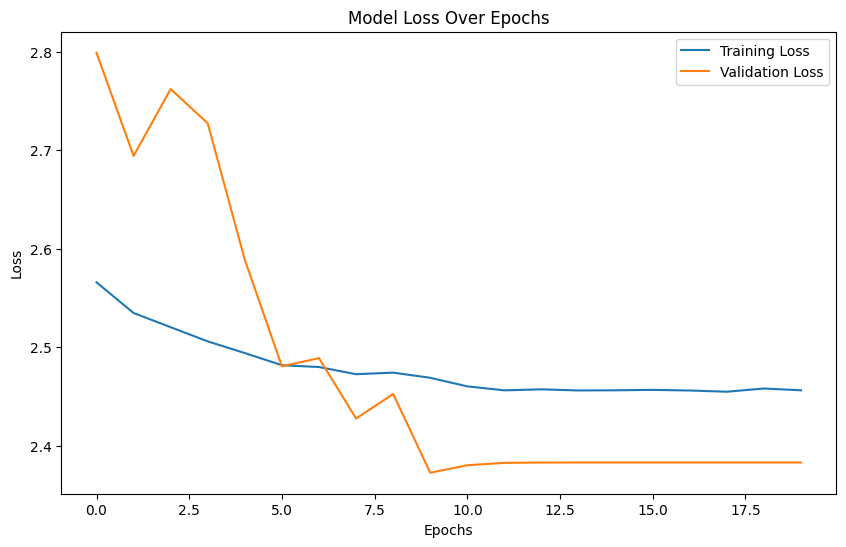

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

y_actual = np.argmax(y_test, axis=1) - 1  # Assuming y_test is in one-hot encoded format

model.save('stat_features_selection_lstm_model_penalty_0.keras')  # HDF5 format


In [ ]:
y_test

array([[1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [ ]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

# Load your saved model
model = load_model('stat_features_selection_lstm_model_penalty_0.keras')

# Make predictions
predictions_prob = model.predict(X_test)

# Convert probabilities to class labels (-1, 0, 1)
predictions_class = np.argmax(predictions_prob, axis=1) - 1

# Convert y_test from one-hot encoded format back to original class labels
y_test_actual = np.argmax(y_test, axis=1) - 1

# Create DataFrame with predictions and actual values with proper indexes
results_df = pd.DataFrame({
    'Actual': y_test_actual,
    'signal': predictions_class
}, index=test_idx)

# Display the DataFrame
print(results_df)


275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
                     Actual  signal
2024-01-01 00:00:00      -1      -1
2024-01-01 01:00:00       0      -1
2024-01-01 02:00:00      -1      -1
2024-01-01 03:00:00       0      -1
2024-01-01 04:00:00       1      -1
...                     ...     ...
2024-12-31 19:00:00      -1      -1
2024-12-31 20:00:00       1      -1
2024-12-31 21:00:00      -1      -1
2024-12-31 22:00:00       0      -1
2024-12-31 23:00:00       0      -1

[8784 rows x 2 columns]


In [ ]:
y_categorical

array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [ ]:

stat_signal_result_df = results_df
stat_signal_result_df

,Actual,signal
2024-01-01 00:00:00,-1,-1
2024-01-01 01:00:00,0,-1
2024-01-01 02:00:00,-1,-1
2024-01-01 03:00:00,0,-1
2024-01-01 04:00:00,1,-1
...,...,...
2024-12-31 19:00:00,-1,-1
2024-12-31 20:00:00,1,-1
2024-12-31 21:00:00,-1,-1
2024-12-31 22:00:00,0,-1


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming 'stat_signal_result_df' is the DataFrame created in the previous cell
y_true = stat_signal_result_df['Actual']
y_pred = stat_signal_result_df['signal']

# Calculate metrics
# Use 'weighted' average for multi-class classification to account for label imbalance
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Weighted): {precision:.4f}")
print(f"Recall (Weighted): {recall:.4f}")
print(f"F1 Score (Weighted): {f1:.4f}")

# If you want metrics for each class (e.g., -1, 0, 1)
print("\\nMetrics per class:")
precision_per_class = precision_score(y_true, y_pred, average=None, zero_division=0)
recall_per_class = recall_score(y_true, y_pred, average=None, zero_division=0)
f1_per_class = f1_score(y_true, y_pred, average=None, zero_division=0)
labels = sorted(y_true.unique()) # Get the unique class labels

for i, label in enumerate(labels):
    print(f"  Class {label}:")
    print(f"    Precision: {precision_per_class[i]:.4f}")
    print(f"    Recall:    {recall_per_class[i]:.4f}")
    print(f"    F1 Score:  {f1_per_class[i]:.4f}")


Accuracy: 0.4547
Precision (Weighted): 0.6147
Recall (Weighted): 0.4547
F1 Score (Weighted): 0.3842
\nMetrics per class:
  Class -1:
    Precision: 0.3584
    Recall:    0.9460
    F1 Score:  0.5199
  Class 0:
    Precision: 0.8437
    Recall:    0.4368
    F1 Score:  0.5756
  Class 1:
    Precision: 0.5900
    Recall:    0.0206
    F1 Score:  0.0398


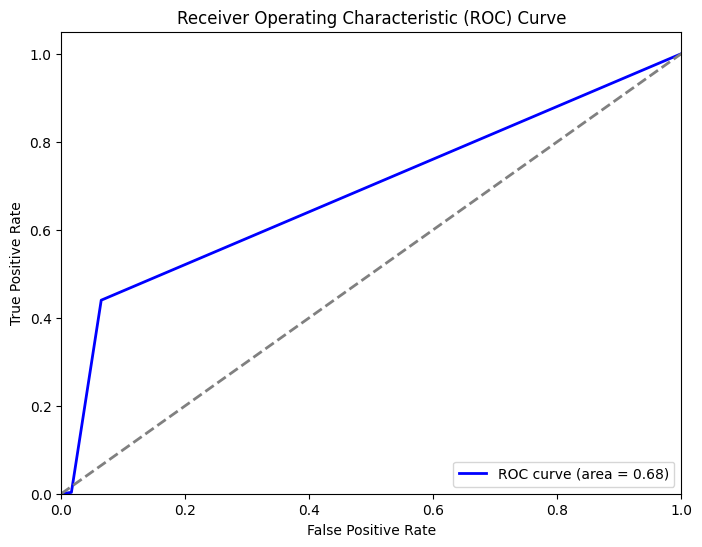

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score


mask = y_pred != 0
y_true_filtered = y_true[mask]
y_pred_filtered = predictions_class[mask]

# Binarize the labels
# Here, we assume y_pred_filtered contains probabilities or scores for class 1
y_true_binary = np.where(y_true_filtered == 1, 1, 0)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_true_binary, y_pred_filtered)

# Calculate AUC
roc_auc = roc_auc_score(y_true_binary, y_pred_filtered)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


Overall Annual Return: -19.9%
Overall Annual Sharpe Ratio: -0.2105
Maximum Drawdown: -47.99 %
Alpha: 0.8393
Beta: -0.7651

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024      -0.199032    0.488365    -0.765082      0.609396      -0.210517


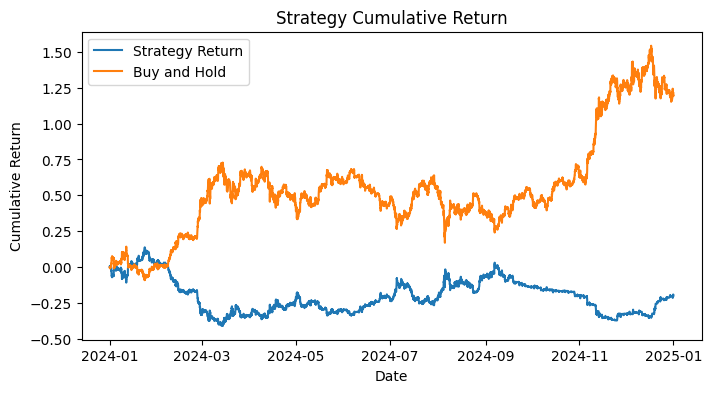

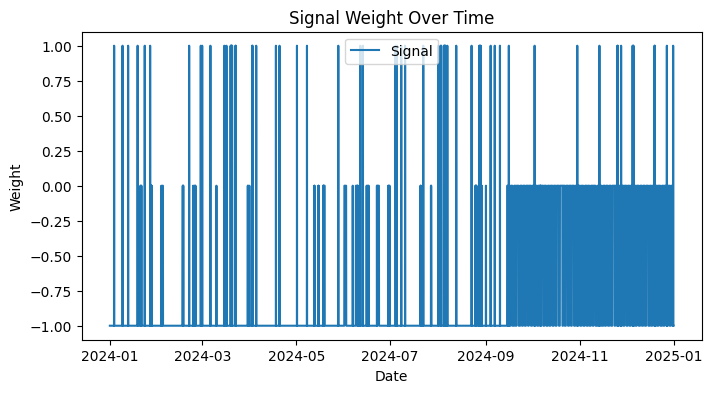

In [ ]:
run_backtest(stat_signal_result_df,name="LSTM_penalty_Stat")

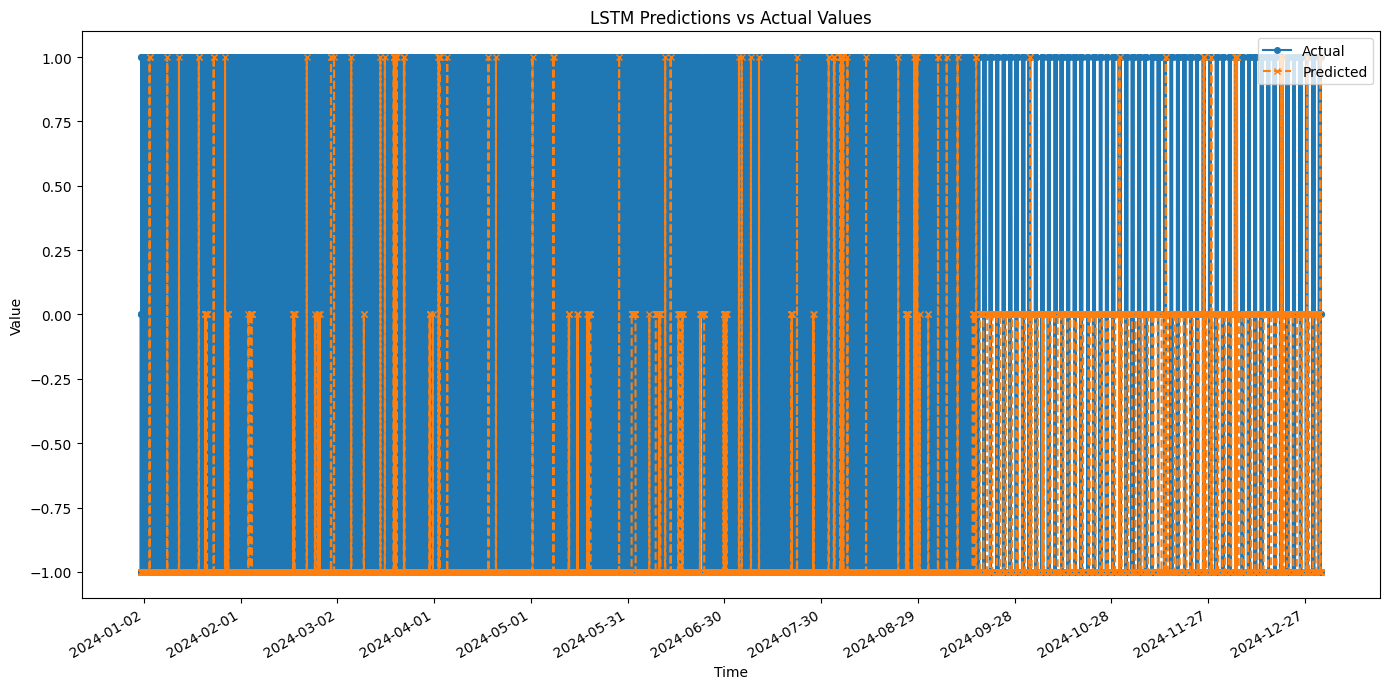

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Plot with proper time indexes
plt.figure(figsize=(14, 7))
plt.plot(results_df.index, results_df['Actual'], label='Actual', marker='o', linestyle='-', markersize=4)
plt.plot(results_df.index, results_df['signal'], label='Predicted', marker='x', linestyle='--', markersize=4)

# Format x-axis if using DatetimeIndex
if isinstance(results_df.index, pd.DatetimeIndex):
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
    plt.gcf().autofmt_xdate()

plt.title('LSTM Predictions vs Actual Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.show()


# Sequential Feature Selection

In [ ]:
import pickle
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

# Load the scalers and feature list
with open('./pickles/seq_feature_scaler.pkl', 'rb') as file:
    feature_scaler = pickle.load(file)

with open('./pickles/seq_target_scaler.pkl', 'rb') as file:
    target_scaler = pickle.load(file)

with open('./pickles/seq_selected_features.pkl', 'rb') as file:
    selected_features = pickle.load(file)

In [ ]:
print(selected_features)

Index(['tanalysis_absa', 'sma_5_20_diff_abs_chg', 'ema_5_20_diff_abs_chg',
       'atr_7_slope', 'atr_14_slope', '10_band_width', 'target',
       'tanalysis_absa_ewm_12h', 'tanalysis_absa_ewm_70h',
       'economy_absa_ewm_70h', 'adoption_absa_ewm_12h',
       'adoption_absa_ewm_70h', 'source_AMBCrypto_last3',
       'source_Bitcoin Magazine_last24', 'reddit_total_sentiment_ewm_5h'],
      dtype='object')


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.callbacks import LearningRateScheduler
from keras.saving import register_keras_serializable
from keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

earlystopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)


@register_keras_serializable(package="Custom", name="directional_penalty_loss")


def asymmetric_trading_loss(y_true, y_pred):
    """
    Custom loss function for Buy/Hold/Sell classification with asymmetric penalties.

    Assumes:
    - y_true is one-hot encoded: [Buy, Hold, Sell] => [[1,0,0], [0,1,0], [0,0,1]]
    - y_pred contains softmax probabilities for [Buy, Hold, Sell]

    Args:
    y_true: Tensor of true labels (batch_size, 3) or (batch_size, timesteps, 3)
    y_pred: Tensor of predicted probabilities (batch_size, 3) or (batch_size, timesteps, 3)

    Returns:
    Scalar tensor representing the mean loss over the batch.
    """
    y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())

    is_true_buy = y_true[..., BUY_INDEX]
    loss_buy_correct = is_true_buy * (-tf.math.log(y_pred[..., BUY_INDEX]))
    penalty_buy_as_hold = is_true_buy * PENALTY_BUY_AS_HOLD * y_pred[..., HOLD_INDEX]
    penalty_buy_as_sell = is_true_buy * PENALTY_BUY_AS_SELL * y_pred[..., SELL_INDEX]
    loss_when_true_buy = loss_buy_correct + penalty_buy_as_hold + penalty_buy_as_sell

    is_true_hold = y_true[..., HOLD_INDEX]
    loss_hold_correct = is_true_hold * (-tf.math.log(y_pred[..., HOLD_INDEX]))
    penalty_hold_as_buy = is_true_hold * PENALTY_HOLD_AS_BUY * y_pred[..., BUY_INDEX]
    penalty_hold_as_sell = is_true_hold * PENALTY_HOLD_AS_SELL * y_pred[..., SELL_INDEX]
    loss_when_true_hold = loss_hold_correct + penalty_hold_as_buy + penalty_hold_as_sell

    # 3. True Label is SELL ([0, 0, 1])
    is_true_sell = y_true[..., SELL_INDEX]
    # Loss component for predicting Sell correctly
    loss_sell_correct = is_true_sell * (-tf.math.log(y_pred[..., SELL_INDEX]))
    # Penalty for predicting Buy when it should be Sell (HIGH PENALTY)
    penalty_sell_as_buy = is_true_sell * PENALTY_SELL_AS_BUY * y_pred[..., BUY_INDEX]
    # Penalty for predicting Hold when it should be Sell
    penalty_sell_as_hold = is_true_sell * PENALTY_SELL_AS_HOLD * y_pred[..., HOLD_INDEX]
    loss_when_true_sell = loss_sell_correct + penalty_sell_as_buy + penalty_sell_as_hold

    total_loss = loss_when_true_buy + loss_when_true_hold + loss_when_true_sell

    final_loss = tf.reduce_mean(total_loss)

    return final_loss


# Assume df is your DataFrame and selected_features is a list of feature column names
# df = load_your_data_function()
# Define learning rate schedule function
def lr_schedule(epoch, lr):
    if epoch < 10:
        return lr
    elif epoch < 20:
        return lr * 0.1
    else:
        return lr * 0.01

# Create learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

X_df = df[selected_features].values
y_df = df['target'].values  # Replace with your target column name
original_indexes = df.index.tolist()

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_df)

# Convert target to categorical signals (-1, 0, 1)
# Ensure y_df contains the values -1, 0, 1
y_categorical = tf.keras.utils.to_categorical(y_df , num_classes=3)

# Define sequence length (time steps to look back)
sequence_length = 12  # Adjust based on your specific problem

# Create sequences for LSTM
X_sequences = []
y_sequences = []
sequence_indexes = []

for i in range(len(X_scaled) - sequence_length):
    X_sequences.append(X_scaled[i:i + sequence_length])
    y_sequences.append(y_categorical[i + sequence_length])
    sequence_indexes.append(original_indexes[i + sequence_length])

# Convert to numpy arrays
X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

# Check the resulting shapes
print(f"X shape: {X_sequences.shape}")  # Should be (samples, sequence_length, num_features)
print(f"y shape: {y_sequences.shape}")  # Should be (samples, 3) for categorical

# Split into training and testing sets
X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(
    X_sequences, y_sequences, sequence_indexes, test_size=0.25062, shuffle=False
)

print(f"Total sequences: {len(sequence_indexes)}")
print(f"Training sequences: {len(train_idx)}")
print(f"Testing sequences: {len(test_idx)}")

# Define your LSTM model for classification
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(sequence_length, X_sequences.shape[2])),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with increased epochs
epochs = 50  # Increase the number of epochs as needed
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test),
                        callbacks=[earlystopping, lr_scheduler],
                        batch_size=32, verbose=1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test Accuracy:', accuracy)

# Predict using the model
y_pred_prob = model.predict(X_test)

# Convert probabilities to class labels
y_pred_class = np.argmax(y_pred_prob, axis=1) - 1  # Subtract 1 to map back to original labels (-1, 0, 1)

# Print or use the predictions
print('Predicted Signals:', y_pred_class)


X shape: (35046, 12, 15)
y shape: (35046, 3)
Total sequences: 35046
Training sequences: 26262
Testing sequences: 8784
Epoch 1/50
821/821 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.3804 - loss: 2.5928 - val_accuracy: 0.3015 - val_loss: 2.9182 - learning_rate: 0.0010
Epoch 2/50
821/821 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.3818 - loss: 2.5294 - val_accuracy: 0.3138 - val_loss: 2.7604 - learning_rate: 0.0010
Epoch 3/50
821/821 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.3805 - loss: 2.5278 - val_accuracy: 0.3029 - val_loss: 2.8209 - learning_rate: 0.0010
Epoch 4/50
821/821 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.3844 - loss: 2.5088 - val_accuracy: 0.3522 - val_loss: 2.6770 - learning_rate: 0.0010
Epoch 5/50
821/821 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.3953 - loss: 2.4804 - val_accuracy: 0.3641 - val_loss: 2.6242 - learning_rate: 0.0010
Epoch 6/50
821/821 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.3954 - loss: 2.4794 - val_accuracy: 0.4180 - val_loss: 2

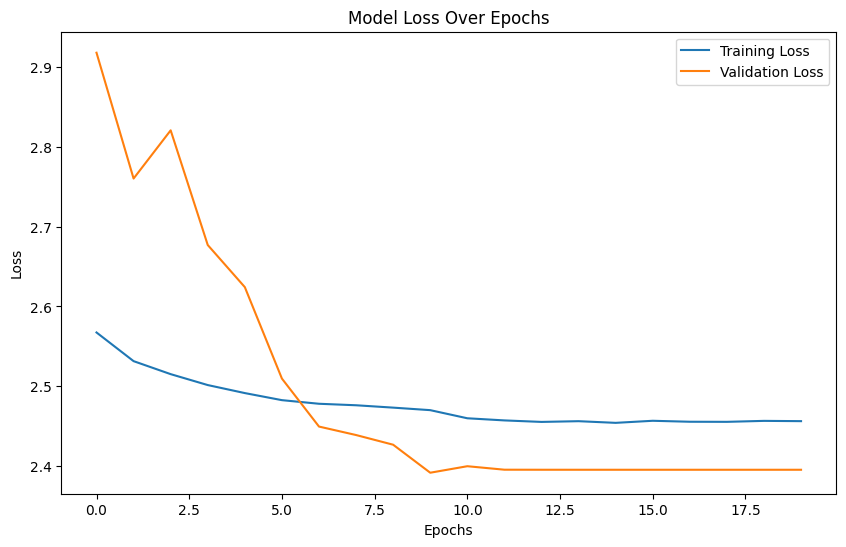

In [ ]:
import matplotlib.pyplot as plt

# Plot loss history (for Keras model)
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [ ]:

model.save('seq_features_selection_lstm_model_penalty_0.keras')  # HDF5 format


In [ ]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

# Load your saved model
model = load_model('seq_features_selection_lstm_model_penalty_0.keras')

# Make predictions
predictions_prob = model.predict(X_test)

# Convert probabilities to class labels (-1, 0, 1)
predictions_class = np.argmax(predictions_prob, axis=1) - 1

# Convert y_test from one-hot encoded format back to original class labels
y_test_actual = np.argmax(y_test, axis=1) - 1

# Create DataFrame with predictions and actual values with proper indexes
results_df = pd.DataFrame({
    'Actual': y_test_actual,
    'signal': predictions_class
}, index=test_idx)

# Display the DataFrame
print(results_df)


275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
                     Actual  signal
2024-01-01 00:00:00      -1      -1
2024-01-01 01:00:00       0      -1
2024-01-01 02:00:00      -1      -1
2024-01-01 03:00:00       0      -1
2024-01-01 04:00:00       1      -1
...                     ...     ...
2024-12-31 19:00:00      -1      -1
2024-12-31 20:00:00       1      -1
2024-12-31 21:00:00      -1      -1
2024-12-31 22:00:00       0      -1
2024-12-31 23:00:00       0      -1

[8784 rows x 2 columns]


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming 'stat_signal_result_df' is the DataFrame created in the previous cell
y_true = stat_signal_result_df['Actual']
y_pred = stat_signal_result_df['signal']

# Calculate metrics
# Use 'weighted' average for multi-class classification to account for label imbalance
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Weighted): {precision:.4f}")
print(f"Recall (Weighted): {recall:.4f}")
print(f"F1 Score (Weighted): {f1:.4f}")

# If you want metrics for each class (e.g., -1, 0, 1)
print("\\nMetrics per class:")
precision_per_class = precision_score(y_true, y_pred, average=None, zero_division=0)
recall_per_class = recall_score(y_true, y_pred, average=None, zero_division=0)
f1_per_class = f1_score(y_true, y_pred, average=None, zero_division=0)
labels = sorted(y_true.unique()) # Get the unique class labels

for i, label in enumerate(labels):
    print(f"  Class {label}:")
    print(f"    Precision: {precision_per_class[i]:.4f}")
    print(f"    Recall:    {recall_per_class[i]:.4f}")
    print(f"    F1 Score:  {f1_per_class[i]:.4f}")


Accuracy: 0.4547
Precision (Weighted): 0.6147
Recall (Weighted): 0.4547
F1 Score (Weighted): 0.3842
\nMetrics per class:
  Class -1:
    Precision: 0.3584
    Recall:    0.9460
    F1 Score:  0.5199
  Class 0:
    Precision: 0.8437
    Recall:    0.4368
    F1 Score:  0.5756
  Class 1:
    Precision: 0.5900
    Recall:    0.0206
    F1 Score:  0.0398


In [ ]:
predictions_class

array([-1, -1, -1, ..., -1, -1, -1])

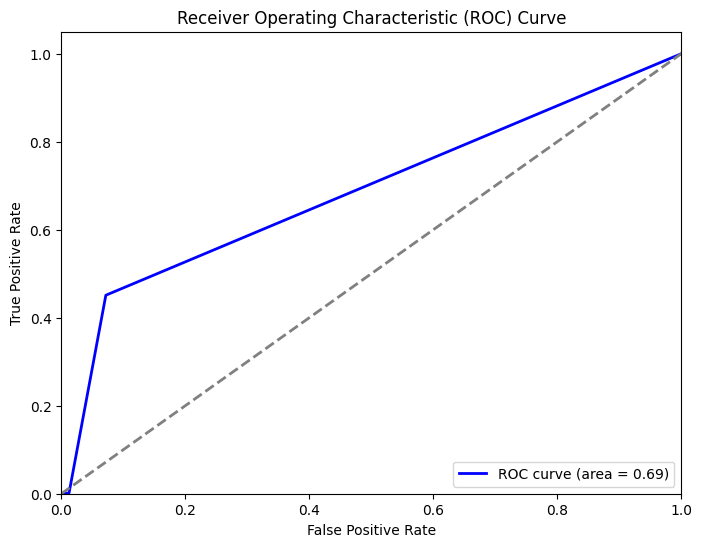

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score


mask = y_pred != 0
y_true_filtered = y_true[mask]
y_pred_filtered = predictions_class[mask]

# Binarize the labels
# Here, we assume y_pred_filtered contains probabilities or scores for class 1
y_true_binary = np.where(y_true_filtered == 1, 1, 0)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_true_binary, y_pred_filtered)

# Calculate AUC
roc_auc = roc_auc_score(y_true_binary, y_pred_filtered)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


Overall Annual Return: -19.9%
Overall Annual Sharpe Ratio: -0.2105
Maximum Drawdown: -47.99 %
Alpha: 0.8393
Beta: -0.7651

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024      -0.199032    0.488365    -0.765082      0.609396      -0.210517


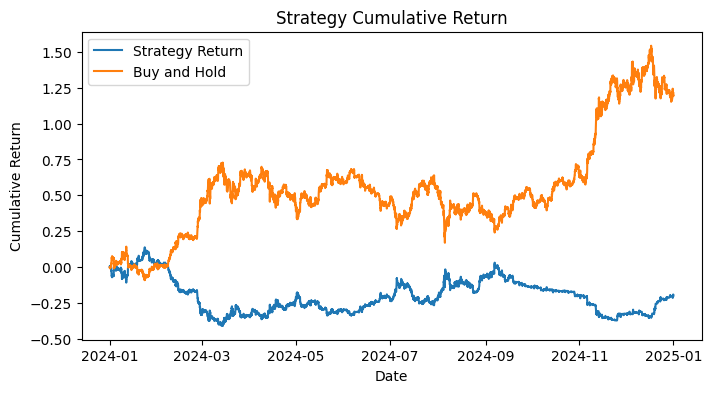

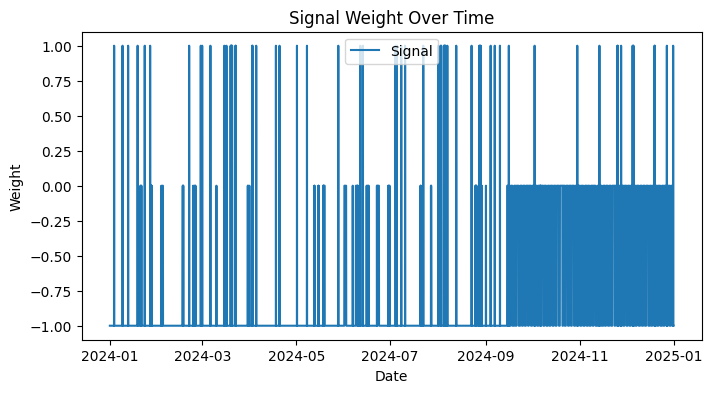

In [ ]:
run_backtest(stat_signal_result_df, name ="LSTM_penalty_Seq")

# Hybrid Pipeline

In [ ]:
import pickle
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

# Load the scalers and feature list
with open('./pickles/hybrid_feature_scaler.pkl', 'rb') as file:
    feature_scaler = pickle.load(file)

with open('./pickles/hybrid_target_scaler.pkl', 'rb') as file:
    target_scaler = pickle.load(file)

with open('./pickles/hybrid_selected_features.pkl', 'rb') as file:
    selected_features = pickle.load(file)

In [ ]:
print(selected_features)

Index(['tanalysis_absa', 'sma_5_20_diff_abs_chg', 'ema_5_20_diff_abs_chg',
       'atr_7_slope', 'atr_14_slope', '10_band_width', 'target',
       'tanalysis_absa_ewm_12h', 'tanalysis_absa_ewm_70h',
       'economy_absa_ewm_70h', 'adoption_absa_ewm_12h',
       'adoption_absa_ewm_70h', 'source_AMBCrypto_last3',
       'source_Bitcoin Magazine_last24', 'reddit_total_sentiment_ewm_5h'],
      dtype='object')


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.callbacks import LearningRateScheduler
from keras.saving import register_keras_serializable
from keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

earlystopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)


@register_keras_serializable(package="Custom", name="directional_penalty_loss")


def asymmetric_trading_loss(y_true, y_pred):
    """
    Custom loss function for Buy/Hold/Sell classification with asymmetric penalties.

    Assumes:
    - y_true is one-hot encoded: [Buy, Hold, Sell] => [[1,0,0], [0,1,0], [0,0,1]]
    - y_pred contains softmax probabilities for [Buy, Hold, Sell]

    Args:
    y_true: Tensor of true labels (batch_size, 3) or (batch_size, timesteps, 3)
    y_pred: Tensor of predicted probabilities (batch_size, 3) or (batch_size, timesteps, 3)

    Returns:
    Scalar tensor representing the mean loss over the batch.
    """
    y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())

    is_true_buy = y_true[..., BUY_INDEX]
    loss_buy_correct = is_true_buy * (-tf.math.log(y_pred[..., BUY_INDEX]))
    penalty_buy_as_hold = is_true_buy * PENALTY_BUY_AS_HOLD * y_pred[..., HOLD_INDEX]
    penalty_buy_as_sell = is_true_buy * PENALTY_BUY_AS_SELL * y_pred[..., SELL_INDEX]
    loss_when_true_buy = loss_buy_correct + penalty_buy_as_hold + penalty_buy_as_sell

    is_true_hold = y_true[..., HOLD_INDEX]
    loss_hold_correct = is_true_hold * (-tf.math.log(y_pred[..., HOLD_INDEX]))
    penalty_hold_as_buy = is_true_hold * PENALTY_HOLD_AS_BUY * y_pred[..., BUY_INDEX]
    penalty_hold_as_sell = is_true_hold * PENALTY_HOLD_AS_SELL * y_pred[..., SELL_INDEX]
    loss_when_true_hold = loss_hold_correct + penalty_hold_as_buy + penalty_hold_as_sell

    # 3. True Label is SELL ([0, 0, 1])
    is_true_sell = y_true[..., SELL_INDEX]
    # Loss component for predicting Sell correctly
    loss_sell_correct = is_true_sell * (-tf.math.log(y_pred[..., SELL_INDEX]))
    # Penalty for predicting Buy when it should be Sell (HIGH PENALTY)
    penalty_sell_as_buy = is_true_sell * PENALTY_SELL_AS_BUY * y_pred[..., BUY_INDEX]
    # Penalty for predicting Hold when it should be Sell
    penalty_sell_as_hold = is_true_sell * PENALTY_SELL_AS_HOLD * y_pred[..., HOLD_INDEX]
    loss_when_true_sell = loss_sell_correct + penalty_sell_as_buy + penalty_sell_as_hold

    total_loss = loss_when_true_buy + loss_when_true_hold + loss_when_true_sell

    final_loss = tf.reduce_mean(total_loss)

    return final_loss


# Assume df is your DataFrame and selected_features is a list of feature column names
# df = load_your_data_function()
# Define learning rate schedule function
def lr_schedule(epoch, lr):
    if epoch < 10:
        return lr
    elif epoch < 20:
        return lr * 0.1
    else:
        return lr * 0.01

# Create learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

X_df = df[selected_features].values
y_df = df['target'].values  # Replace with your target column name
original_indexes = df.index.tolist()

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_df)

# Convert target to categorical signals (-1, 0, 1)
# Ensure y_df contains the values -1, 0, 1
y_categorical = tf.keras.utils.to_categorical(y_df , num_classes=3)

# Define sequence length (time steps to look back)
sequence_length = 12  # Adjust based on your specific problem

# Create sequences for LSTM
X_sequences = []
y_sequences = []
sequence_indexes = []

for i in range(len(X_scaled) - sequence_length):
    X_sequences.append(X_scaled[i:i + sequence_length])
    y_sequences.append(y_categorical[i + sequence_length])
    sequence_indexes.append(original_indexes[i + sequence_length])

# Convert to numpy arrays
X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

# Check the resulting shapes
print(f"X shape: {X_sequences.shape}")  # Should be (samples, sequence_length, num_features)
print(f"y shape: {y_sequences.shape}")  # Should be (samples, 3) for categorical

# Split into training and testing sets
X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(
    X_sequences, y_sequences, sequence_indexes, test_size=0.25062, shuffle=False
)

print(f"Total sequences: {len(sequence_indexes)}")
print(f"Training sequences: {len(train_idx)}")
print(f"Testing sequences: {len(test_idx)}")

# Define your LSTM model for classification
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(sequence_length, X_sequences.shape[2])),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with increased epochs
epochs = 50  # Increase the number of epochs as needed
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test),
                        callbacks=[earlystopping, lr_scheduler],
                        batch_size=32, verbose=1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test Accuracy:', accuracy)

# Predict using the model
y_pred_prob = model.predict(X_test)

# Convert probabilities to class labels
y_pred_class = np.argmax(y_pred_prob, axis=1) - 1  # Subtract 1 to map back to original labels (-1, 0, 1)

# Print or use the predictions
print('Predicted Signals:', y_pred_class)


X shape: (35046, 12, 15)
y shape: (35046, 3)
Total sequences: 35046
Training sequences: 26262
Testing sequences: 8784
Epoch 1/50
821/821 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.3862 - loss: 2.5884 - val_accuracy: 0.3015 - val_loss: 2.7997 - learning_rate: 0.0010
Epoch 2/50
821/821 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.3819 - loss: 2.5291 - val_accuracy: 0.3015 - val_loss: 2.7221 - learning_rate: 0.0010
Epoch 3/50
821/821 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.3876 - loss: 2.5069 - val_accuracy: 0.3149 - val_loss: 2.6962 - learning_rate: 0.0010
Epoch 4/50
821/821 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.3873 - loss: 2.4966 - val_accuracy: 0.3981 - val_loss: 2.5929 - learning_rate: 0.0010
Epoch 5/50
821/821 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.3903 - loss: 2.4897 - val_accuracy: 0.4185 - val_loss: 2.5293 - learning_rate: 0.0010
Epoch 6/50
821/821 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.3965 - loss: 2.4744 - val_accuracy: 0.4068 - val_loss: 2

In [ ]:
y_pred_class

array([-1, -1, -1, ..., -1, -1, -1])

In [ ]:
model.save('hybrid_features_selection_lstm_model_penalty_0.keras')  # HDF5 format


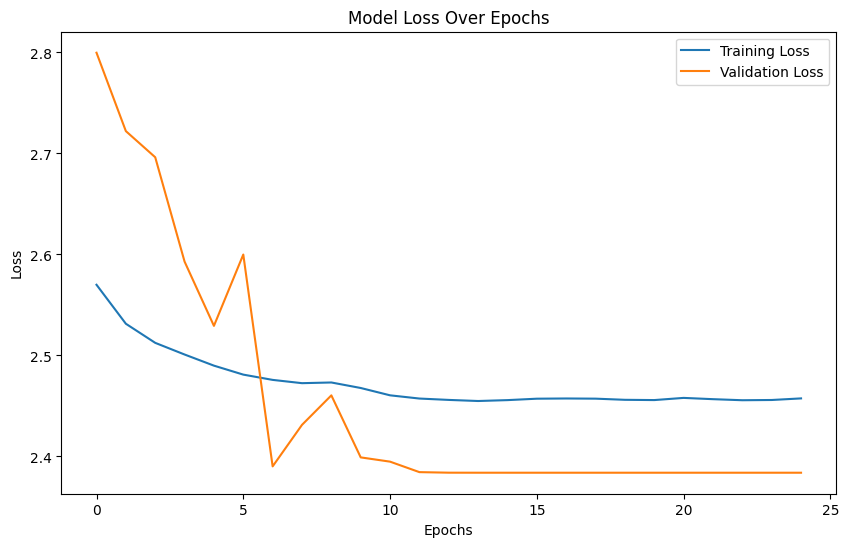

In [ ]:
import matplotlib.pyplot as plt

# Plot loss history (for Keras model)
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [ ]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

# Load your saved model
model = load_model('hybrid_features_selection_lstm_model_penalty_0.keras')

# Make predictions
predictions_prob = model.predict(X_test)

# Convert probabilities to class labels (-1, 0, 1)
predictions_class = np.argmax(predictions_prob, axis=1) - 1

# Convert y_test from one-hot encoded format back to original class labels
y_test_actual = np.argmax(y_test, axis=1) - 1

# Create DataFrame with predictions and actual values with proper indexes
results_df = pd.DataFrame({
    'Actual': y_test_actual,
    'signal': predictions_class
}, index=test_idx)
stat_signal_result_df = results_df
# Display the DataFrame
print(results_df)


275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
                     Actual  signal
2024-01-01 00:00:00      -1      -1
2024-01-01 01:00:00       0      -1
2024-01-01 02:00:00      -1      -1
2024-01-01 03:00:00       0      -1
2024-01-01 04:00:00       1      -1
...                     ...     ...
2024-12-31 19:00:00      -1      -1
2024-12-31 20:00:00       1      -1
2024-12-31 21:00:00      -1      -1
2024-12-31 22:00:00       0      -1
2024-12-31 23:00:00       0      -1

[8784 rows x 2 columns]


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming 'stat_signal_result_df' is the DataFrame created in the previous cell
y_true = stat_signal_result_df['Actual']
y_pred = stat_signal_result_df['signal']

# Calculate metrics
# Use 'weighted' average for multi-class classification to account for label imbalance
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Weighted): {precision:.4f}")
print(f"Recall (Weighted): {recall:.4f}")
print(f"F1 Score (Weighted): {f1:.4f}")

# If you want metrics for each class (e.g., -1, 0, 1)
print("\\nMetrics per class:")
precision_per_class = precision_score(y_true, y_pred, average=None, zero_division=0)
recall_per_class = recall_score(y_true, y_pred, average=None, zero_division=0)
f1_per_class = f1_score(y_true, y_pred, average=None, zero_division=0)
labels = sorted(y_true.unique()) # Get the unique class labels

for i, label in enumerate(labels):
    print(f"  Class {label}:")
    print(f"    Precision: {precision_per_class[i]:.4f}")
    print(f"    Recall:    {recall_per_class[i]:.4f}")
    print(f"    F1 Score:  {f1_per_class[i]:.4f}")


Accuracy: 0.4477
Precision (Weighted): 0.6075
Recall (Weighted): 0.4477
F1 Score (Weighted): 0.3699
\nMetrics per class:
  Class -1:
    Precision: 0.3554
    Recall:    0.9562
    F1 Score:  0.5182
  Class 0:
    Precision: 0.8484
    Recall:    0.4239
    F1 Score:  0.5654
  Class 1:
    Precision: 0.5652
    Recall:    0.0045
    F1 Score:  0.0090


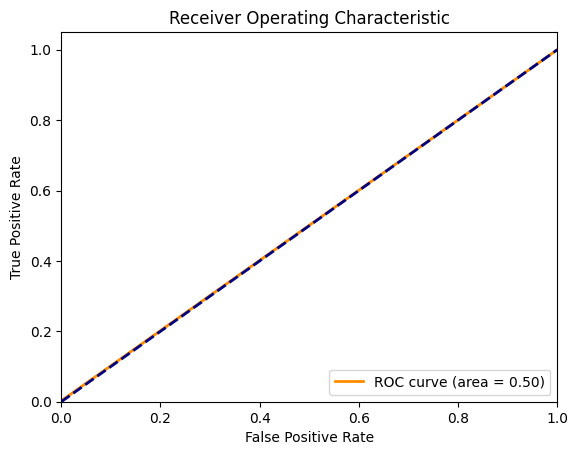

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score


mask = y_pred != 0
y_true_filtered = y_true[mask]
y_pred_filtered = predictions_class[mask]

# Binarize the labels
# Here, we assume y_pred_filtered contains probabilities or scores for class 1
y_true_binary = np.where(y_true_filtered == 1, 1, 0)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_true_binary, y_pred_filtered)

# Calculate AUC
roc_auc = roc_auc_score(y_true_binary, y_pred_filtered)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


Overall Annual Return: -48.68%
Overall Annual Sharpe Ratio: -1.1168
Maximum Drawdown: -62.12 %
Alpha: 0.2776
Beta: -0.851

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024      -0.486832    0.489933    -0.850977      0.244996      -1.116822


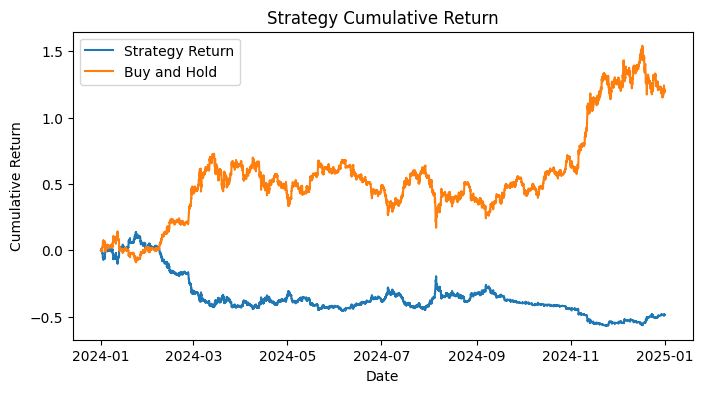

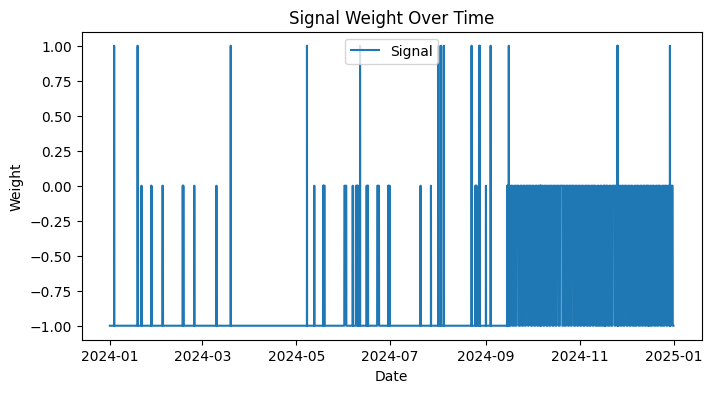

In [ ]:
run_backtest(stat_signal_result_df, name ="LSTM_penalty_Hybrid")